# 人流量计数+足迹追踪+图表可视化显示

MMtracking 预训练模型库 Model Zoo：https://mmtracking.readthedocs.io/en/latest/model_zoo.html

如果报错`CUDA out of memory.`则重启前面几个代码的`kernel`即可。

作者：同济子豪兄 2022-4-21

## 进入 MMTracking 主目录

In [1]:
import os
os.chdir('mmtracking')
os.listdir()

['.git',
 '.circleci',
 '.dev_scripts',
 '.github',
 '.gitignore',
 '.pre-commit-config.yaml',
 '.readthedocs.yml',
 'CITATION.cff',
 'LICENSE',
 'MANIFEST.in',
 'README.md',
 'README_zh-CN.md',
 'configs',
 'demo',
 'docker',
 'docs',
 'mmtrack',
 'model-index.yml',
 'requirements.txt',
 'requirements',
 'resources',
 'setup.cfg',
 'setup.py',
 'tests',
 'tools',
 'mmtrack.egg-info',
 'checkpoints',
 'outputs',
 'data',
 'bytetrack_zihao']

## 导入工具包

In [2]:
# 导入 opencv-python
import cv2

import mmcv

import numpy as np

import random

import seaborn as sns

from tqdm import tqdm

# 导入可视化工具包 matplotlib，并让绘制的图像嵌入在 notebook 中
import matplotlib.pyplot as plt
%matplotlib inline

import mmcv
import tempfile
from mmtrack.apis import inference_mot, init_model
from mmtrack.core import imshow_tracks, results2outs
    
# 定义可视化图像函数，输入图像 array，可视化图像
def show_img_from_array(img):
    '''输入 array，matplotlib 可视化格式为 RGB，因此需将 BGR 转 RGB，最后可视化出来'''
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.show()

def get_color(seed):
    '''
    传入追踪ID，生成专属颜色
    '''
    random.seed(seed)
    # 从调色板中随机挑选一种颜色
    bbox_color = random.choice(palette)
    bbox_color = [int(255 * c) for c in bbox_color][::-1]
    return bbox_color

## 基础可视化配置

In [3]:
from mmtrack.core import imshow_tracks, results2outs

# 目标检测框线宽
thickness = 2

# 轨迹线粗细
trace_radius = 10

# 目标检测置信度阈值
score_thr = 0.0

# 字体大小
font_scale = 0.4
 
# 置信度和 ID 单个数字的宽高
text_width = 9
text_height = 13

# 类别信息
classes = None

# 生成调色板
palette = sns.color_palette('hls',30)

# 目标检测框线宽
thickness = 2

# 轨迹线粗细
trace_radius = 10

# 目标检测置信度阈值
score_thr=0.0

# 字体大小
font_scale=0.4

# 置信度和 ID 单个数字的宽高
text_width = 9
text_height = 13

# 类别信息
classes = None

## 辅助函数

In [4]:
def get_color(seed):
    random.seed(seed)
    # 从调色板中随机挑选一种颜色
    bbox_color = random.choice(palette)
    bbox_color = [int(255 * c) for c in bbox_color][::-1]
    return bbox_color

def process_result(result):
    '''处理单帧函数，输入MOT多目标追踪结果，输出 MOT多目标追踪可视化图像、所有目标轨迹中心点坐标'''

    #######################
    # 整理多目标追踪结果
    #######################
    # 进一步整理result结果
    outs_track = results2outs(bbox_results=result.get('track_bboxes', None))

    # 取出结果
    bboxes = outs_track.get('bboxes', None)
    labels = outs_track.get('labels', None)
    ids = outs_track.get('ids', None)

    # 目标检测框的 x坐标 不超过图像宽度
    bboxes[:, [0,2]] = np.clip(bboxes[:, [0,2]], 0, img.shape[1])
    # 目标检测框的 y坐标 不超过图像高度
    bboxes[:, [1,3]] = np.clip(bboxes[:, [1,3]], 0, img.shape[0])

    # 筛选出目标检测置信度大于指定阈值的目标，并取出其索引、目标检测、类别、ID信息
    inds = np.where(bboxes[:, -1] > score_thr)[0]
    bboxes = bboxes[inds]
    labels = labels[inds]
    ids = ids[inds]

    #######################
    # 遍历每个目标，可视化
    #######################
    trace_coords_frame = [] # 存放当前帧画面中 所有目标轨迹中心点坐标
    for i, (bbox, label, id) in enumerate(zip(bboxes, labels, ids)):
        # 获取目标检测框的左上角、右下角坐标，及置信度
        x1, y1, x2, y2 = bbox[:4].astype(np.int32)
        score = float(bbox[-1])

        # 绘制目标检测矩形框
        bbox_color = get_color(id)
        cv2.rectangle(img, (x1, y1), (x2, y2), bbox_color, thickness=thickness)

        # 绘制矩形框中心点轨迹点，指定圆心坐标和半径，红色，最后一个参数为线宽，-1表示填充
        # trace_coord = {id:[[(x1+x2)//2, (y1+y2)//2], bbox_color]}
        # trace_coord_obj = [id, [(x1+x2)//2, (y1+y2)//2, bbox_color]] # 目标检测框中心点作为轨迹点
        trace_coord_obj = [id, [(x1+x2)//2, y2, bbox_color]]           # 目标检测框底边中点作为轨迹点
        trace_coords_frame.append(trace_coord_obj)
        
        # 置信度文字
        text = '{:.02f}'.format(score)
        if classes is not None: # 类别信息
            text += f'|{classes[label]}'
        # 绘制置信度文字的背景
        width = len(text) * text_width
        img[y1:y1 + text_height, x1:x1 + width, :] = bbox_color
        # 写置信度文字：图像，文字，左上角坐标，字体，字体大小，颜色，字体粗细
        cv2.putText(img, text, (x1, y1 + text_height - 2), cv2.FONT_HERSHEY_COMPLEX, font_scale, color=(0, 0, 0))

        # ID
        text = str(id)
        # 绘制ID文字的背景
        width = len(text) * text_width
        img[y1 + text_height:y1 + 2 * text_height, x1:x1 + width, :] = bbox_color
        # 写 ID文字：图像，文字，左上角坐标，字体，字体大小，颜色，字体粗细
        cv2.putText(img, str(id), (x1, y1 + 2 * text_height - 2), cv2.FONT_HERSHEY_COMPLEX, font_scale, color=(0, 0, 0))

    return img, trace_coords_frame

## 创建存放图像的临时文件夹

In [5]:
import time
temp_dir = time.strftime('%Y%m%d%H%M%S')

if os.path.exists(temp_dir):
    pass
else:
    os.mkdir(temp_dir)
    print('创建文件夹 {} 用于存放每帧图像'.format(temp_dir))
    os.mkdir(temp_dir+'-plot')
    print('创建文件夹 {} 用于存放每帧图像'.format(temp_dir+'-plot'))

创建文件夹 20220421204616 用于存放每帧图像
创建文件夹 20220421204616-plot 用于存放每帧图像


## 多目标追踪视频处理

In [ ]:
# 输入输出视频路径
input_video = 'data/mot_people_medium.mp4'
output = 'outputs/G2_MOT_people_medium.mp4'

## ByteTrack算法
# 指定 config 配置文件 和 模型权重文件，创建模型
mot_config = './configs/mot/bytetrack/bytetrack_yolox_x_crowdhuman_mot17-private-half.py'
mot_checkpoint = 'https://download.openmmlab.com/mmtracking/mot/bytetrack/bytetrack_yolox_x/bytetrack_yolox_x_crowdhuman_mot17-private-half_20211218_205500-1985c9f0.pth'
# 初始化模型
mot_model = init_model(mot_config, mot_checkpoint, device='cuda:0')

## Deepsort算法
# # 指定 config 配置文件 和 模型权重文件，创建模型
# mot_config = './configs/mot/deepsort/deepsort_faster-rcnn_fpn_4e_mot17-private-half.py'
# # 初始化模型
# mot_model = init_model(mot_config, device='cuda:0')

# 读入待预测视频
imgs = mmcv.VideoReader(input_video)

prog_bar = mmcv.ProgressBar(len(imgs))
out_dir = tempfile.TemporaryDirectory()
out_path = temp_dir

# 人数计数
num = 0
# 记录每一帧的总人数、当前人数
num_per_frame = []

# 记录每一帧的各目标轨迹点坐标
trace_coord_video = []

# 对视频逐帧处理
for frame_id, img in enumerate(imgs):
    
    #######################
    # 运行多目标追踪
    #######################
    result = inference_mot(mot_model, img, frame_id=frame_id)
    
    # 获取当前帧目标检测可视化效果，及各目标轨迹点坐标
    img, trace_coord_frame = process_result(result)
    trace_coord_video.append(trace_coord_frame)
    
    #######################
    # 绘制轨迹点：从第一帧到当前帧 所有目标的轨迹点
    #######################
    for trace_coord_frame in trace_coord_video: # 遍历每一帧
        for trace_coord_obj in trace_coord_frame: # 遍历每一个目标
            # 绘制圆，指定圆心坐标和半径，颜色，最后一个参数为线宽，-1表示填充
            cv2.circle(img, (trace_coord_obj[1][0], trace_coord_obj[1][1]),5, trace_coord_obj[1][2], -1)
            # continue
    
    #######################
    #  获取人数
    #######################
    # 用当前最大的 ID 号作为人数值
    if result['track_bboxes'][0][:,0].any(): # 检测出行人
        num = max(num, 1+max(result['track_bboxes'][0][:,0]))
    else: # 没有检测出行人
        num = num
    num_per_frame.append([frame_id, num, len(trace_coord_frame)])
    # 可视化总人数：图片，添加的文字，左上角坐标，字体，字体大小，颜色，字体粗细
    img = cv2.putText(img, str(int(num)), (25, 150), cv2.FONT_HERSHEY_SIMPLEX, 5, (0, 0, 255), 3)
    # 可视化当前人数
    img = cv2.putText(img, str(len(trace_coord_frame)), (25, 350), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 0, 0), 3)

    # 将处理后的该帧画面图像文件，保存至 /tmp 目录下
    cv2.imwrite(f'{out_path}/{frame_id:06d}.jpg', img)
    
    # 更新进度条
    prog_bar.update()

# 由每一帧的图像文件，生成视频
mmcv.frames2video(out_path, output, fps=imgs.fps, fourcc='mp4v')
out_dir.cleanup()

print('帧图像保存路径',out_path)
print('总人数', int(num))

## 绘制人流量折线图

### 解析多目标追踪结果

In [7]:
num_per_frame[:10]

[[0, 12.0, 12],
 [1, 12.0, 12],
 [2, 12.0, 12],
 [3, 12.0, 12],
 [4, 12.0, 12],
 [5, 12.0, 12],
 [6, 12.0, 12],
 [7, 12.0, 12],
 [8, 12.0, 12],
 [9, 12.0, 12]]

### 绘制人流量折线图

In [8]:
# 时间
X_frames = np.array(num_per_frame)[:,0] / imgs.fps

# 总人流量
Y_people = np.array(num_per_frame)[:,1]

# 当前画面人数
Z_people = np.array(num_per_frame)[:,2]

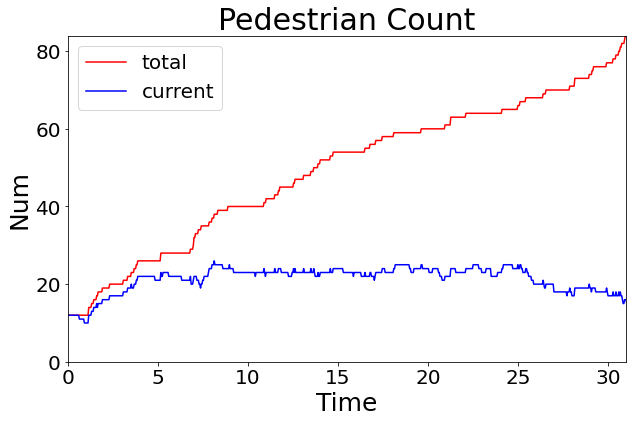

In [9]:
plt.figure(figsize=(10,6))
plt.plot(X_frames[:frame_id+1], Y_people[:frame_id+1], 'r', label='total')
plt.plot(X_frames[:frame_id+1], Z_people[:frame_id+1], 'b', label='current')
plt.ylim(0, int(num))
plt.xlim(0, int(X_frames.max()))
plt.legend(fontsize=20)
plt.tick_params(labelsize=20) # 设置坐标文字大小
plt.xlabel('Time',fontsize=25)
plt.ylabel('Num',fontsize=25)
plt.title('Pedestrian Count',fontsize=30)
plt.show()

### 绘制人流量折线图叠加视频图

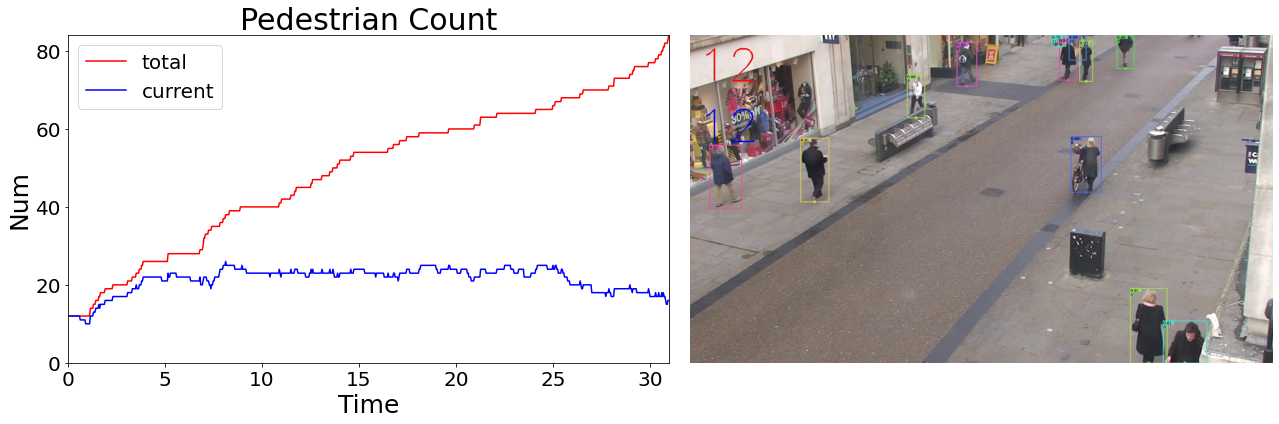

In [10]:
os.chdir(temp_dir)

each = os.listdir()[0]

fig = plt.figure(figsize=(18,6))
# 绘制左图-折线图
ax1 = plt.subplot(1,2,1)
ax1.plot(X_frames[:frame_id+1], Y_people[:frame_id+1], 'r', label='total')
ax1.plot(X_frames[:frame_id+1], Z_people[:frame_id+1], 'b', label='current')
plt.ylim(0, int(num))
plt.xlim(0, int(X_frames.max()))
ax1.legend(fontsize=20)
ax1.tick_params(labelsize=20) # 设置坐标文字大小
plt.xlabel('Time',fontsize=25)
plt.ylabel('Num',fontsize=25)
plt.title('Pedestrian Count',fontsize=30)
# 绘制右图-视频图
ax2 = plt.subplot(1,2,2)
im = plt.imread(each)
ax2.imshow(im)
ax2.axis('off')

plt.tight_layout()

fig.savefig('../test.jpg')

os.chdir('../')

### 生成折线图和视频的同步视频

In [11]:
os.chdir(temp_dir)

In [ ]:
total_frames = np.array(num_per_frame)[:,0].max()
with tqdm(total=total_frames) as pbar:

    for frame_id, each in enumerate(os.listdir()):
        try:
            fig = plt.figure(figsize=(18,6))
            # 绘制左图-折线图
            ax1 = plt.subplot(1,2,1)
            ax1.plot(X_frames[:frame_id+1], Y_people[:frame_id+1], 'r', label='total')
            ax1.plot(X_frames[:frame_id+1], Z_people[:frame_id+1], 'b', label='current')
            plt.ylim(0, int(num))
            plt.xlim(0, int(X_frames.max()))
            ax1.legend(fontsize=20)
            ax1.tick_params(labelsize=20) # 设置坐标文字大小
            plt.xlabel('Time',fontsize=25)
            plt.ylabel('Num',fontsize=25)
            plt.title('Pedestrian Count',fontsize=30)
            # 绘制右图-视频图
            ax2 = plt.subplot(1,2,2)
            im = plt.imread(each)
            ax2.imshow(im)
            ax2.axis('off')

            plt.tight_layout()
            fig.savefig(f"../{temp_dir+'-plot'}/{frame_id:06d}.jpg")
        except:
            pass
        pbar.update()

os.chdir('../')

# 由每一帧的图像文件，生成视频
mmcv.frames2video(temp_dir+'-plot', 'outputs/G2_count_plot.mp4', fps=imgs.fps, fourcc='mp4v')